# Brain MRI Classification (1)
### Alexandru LICURICEANU - 341C4

### Setup

In [82]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import PIL
from PIL import Image, ImageFilter
import cv2
from tqdm import tqdm
import sys
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_STATE = 123
NUM_EPOCHS = 10
LABELS = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

print(f"Cuda: {torch.cuda.is_available()}")

%matplotlib inline
plt.style.use('default')

Cuda: True


### Task 1

In [83]:
class BrainTumorDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.image_labels = []

        self.labels = LABELS

        for label in self.labels:

            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):

                for file_name in os.listdir(label_dir):
                    file_path = os.path.join(label_dir, file_name)
                    self.image_paths.append(file_path)
                    self.image_labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.image_labels[index]

        image = PIL.Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels.index(label)
        
        return image, label
    

train_set = BrainTumorDataset(root_dir='./Training')
test_set = BrainTumorDataset(root_dir='./Testing')

print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")

Train size: 2870, Test size: 394


### Task 2

In [84]:
def split_train_val(dataset, val_size=0.2):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(val_size * dataset_size))

    np.random.seed(RANDOM_STATE)
    np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    return train_dataset, val_dataset

train_set, val_set = split_train_val(train_set, val_size=0.2)

print(f"Train size: {len(train_set)}, Val size: {len(val_set)}, Test size: {len(test_set)}")

Train size: 2296, Val size: 574, Test size: 394


### Task 3

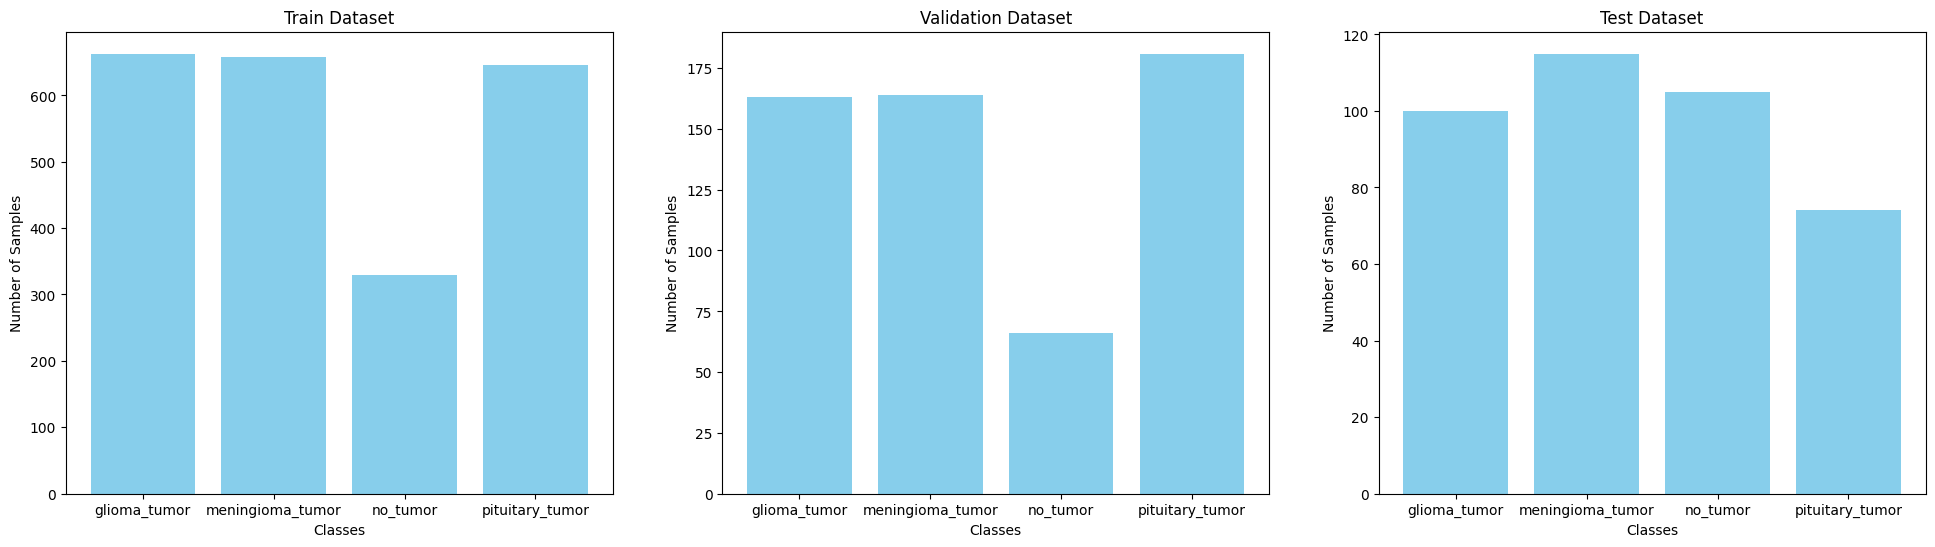

In [85]:
def plot_class_distribution(dataset, title, ax_index):
    labels = [label for _, label in dataset]
    unique, counts = np.unique(labels, return_counts=True)
    ax = axes[ax_index]
    ax.bar(unique, counts, color='skyblue')
    ax.set_xlabel("Classes")
    ax.set_ylabel("Number of Samples")
    ax.set_title(title)
    # Replace the x-axis labels with the class names
    ax.set_xticks(unique)
    ax.set_xticklabels(LABELS)
    plt.title(title)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

plot_class_distribution(train_set, "Train Dataset", 0)
plot_class_distribution(val_set, "Validation Dataset", 1)
plot_class_distribution(test_set, "Test Dataset", 2)

### Task 4

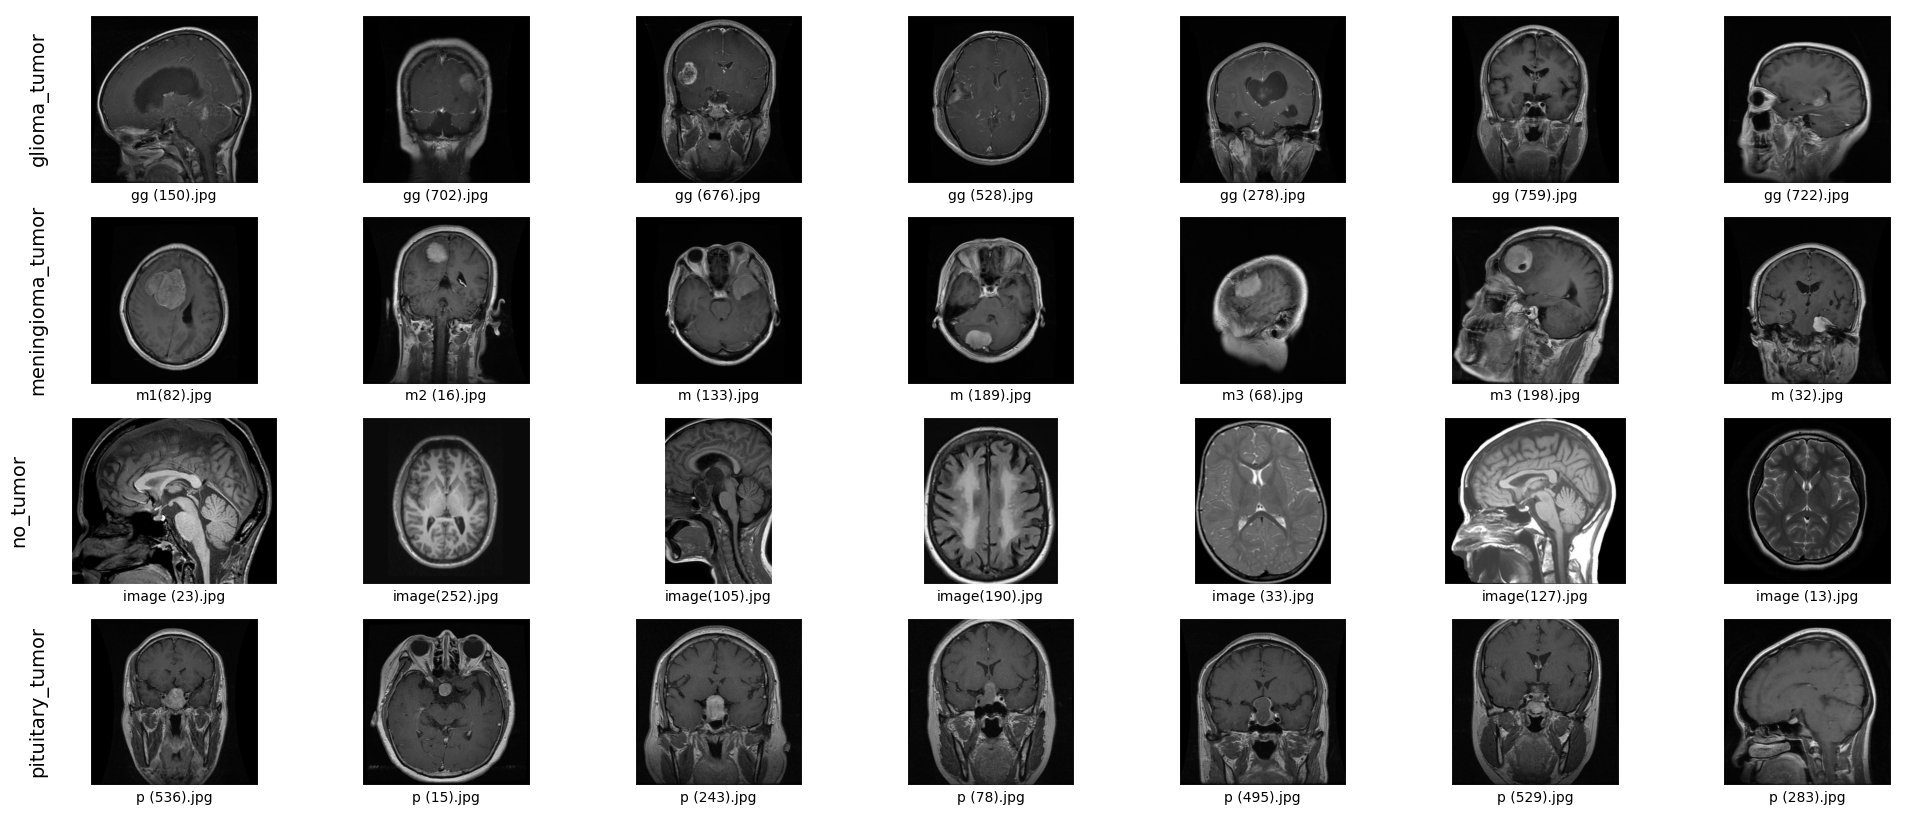

In [86]:
def plot_sample_images(nr_images_each):
    fig, axes = plt.subplots(len(LABELS), nr_images_each, figsize=(24, 10))

    for i, label in enumerate(LABELS):
        image_files = os.listdir(f"Training/{label}")
        np.random.shuffle(image_files)

        axes[i][0].set_ylabel(label, fontsize=14)
        image_files = image_files[:nr_images_each]

        for j, file_name in enumerate(image_files):

            image_path = os.path.join(f"Training/{label}", file_name)
            image = PIL.Image.open(image_path)
            axes[i][j].imshow(image)
            axes[i][j].set_title(file_name, fontsize=10, y=-0.15)
            
            # "Hide" the axes without hiding the title.
            axis_color = 'white'
            axes[i][j].spines['top'].set_color(axis_color)
            axes[i][j].spines['bottom'].set_color(axis_color)
            axes[i][j].spines['left'].set_color(axis_color)
            axes[i][j].spines['right'].set_color(axis_color)
            axes[i][j].tick_params(axis='x', colors=axis_color)
            axes[i][j].tick_params(axis='y', colors=axis_color)

plot_sample_images(nr_images_each=7)

### Task 5

Train Dataset channel distribution: {1: 0, 2: 0, 3: 2296}
Validation Dataset channel distribution: {1: 0, 2: 0, 3: 574}
Test Dataset channel distribution: {1: 0, 2: 0, 3: 394}


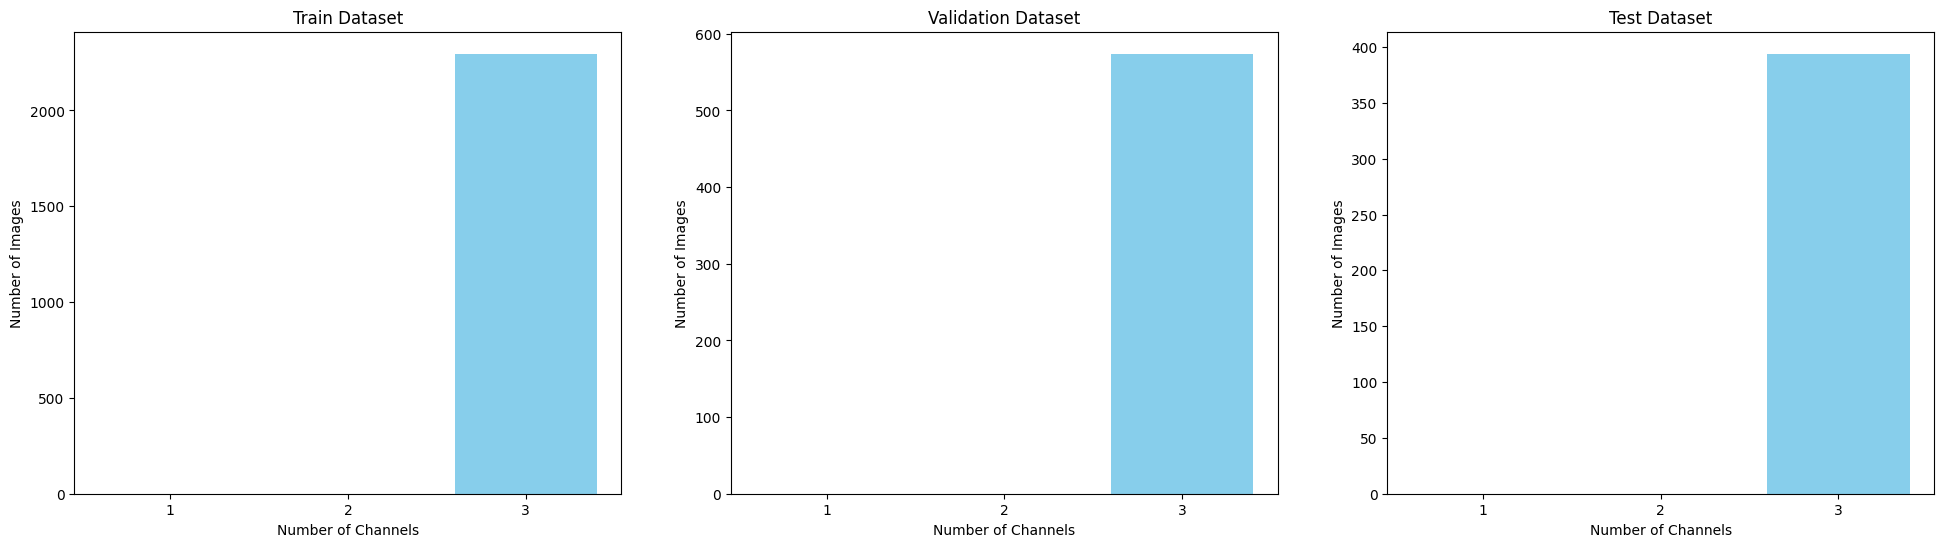

In [87]:
def plot_channel_distribution(dataset, title, ax_index):

    channel_counts = {1: 0, 2: 0, 3: 0}
    
    for image, _ in dataset:
        channels = len(image.getbands())
        
        if channels in channel_counts:
            channel_counts[channels] += 1
        else:
            channel_counts[channels] = 1

    ax = axes[ax_index]
    ax.bar(channel_counts.keys(), channel_counts.values(), color='skyblue')
    ax.set_xlabel('Number of Channels')
    ax.set_ylabel('Number of Images')
    ax.set_title(title)
    ax.set_xticks([1, 2, 3])
    plt.title(title)

    print(f"{title} channel distribution: {channel_counts}")

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
plot_channel_distribution(train_set, "Train Dataset", 0)
plot_channel_distribution(val_set, "Validation Dataset", 1)
plot_channel_distribution(test_set, "Test Dataset", 2)

Train Dataset width distribution: min = 180, max = 1375
Train Dataset height distribution: min = 198, max = 1446


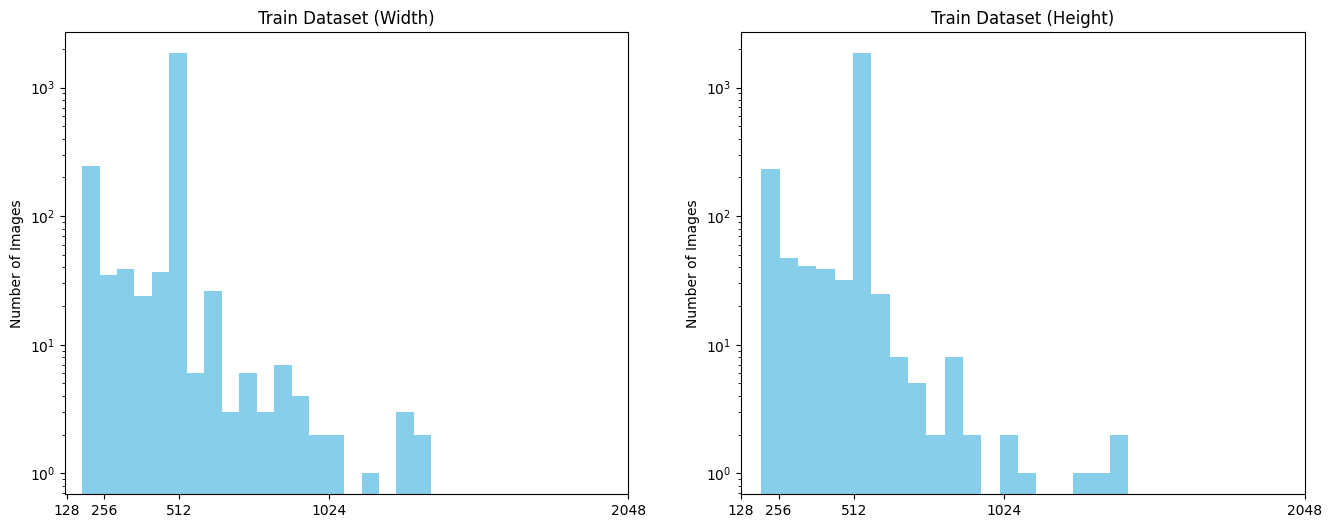

In [88]:
def plot_size_distribution(dataset, title, ax, dimension='width', yscale='linear', bins=20):
    sizes = []
    
    for image, _ in dataset:
        if isinstance(image, torch.Tensor):
            if dimension == 'width':
                sizes.append(image.shape[2])
            elif dimension == 'height':
                sizes.append(image.shape[1])
        else:
            if dimension == 'width':
                sizes.append(image.width)
            elif dimension == 'height':
                sizes.append(image.height)

    sizes = np.array(sizes)

    ax.hist(sizes, bins=bins, color='skyblue')
    ax.set_ylabel("Number of Images")
    ax.set_title(f"{title} ({dimension.capitalize()})")
    ax.set_yscale(yscale)

    min_size = sizes.min()
    max_size = sizes.max()

    start_exp = int(np.floor(np.log2(min_size)))
    end_exp = int(np.ceil(np.log2(max_size)))

    xticks = [2**i for i in range(start_exp, end_exp + 1)]
    
    ax.set_xticks(xticks)

    print(f"{title} {dimension} distribution: min = {min_size}, max = {max_size}")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_size_distribution(train_set, "Train Dataset", axes[0], dimension='width', yscale='log')
plot_size_distribution(train_set, "Train Dataset", axes[1], dimension='height', yscale='log')

Resized Train Dataset width distribution: min = 224, max = 224
Resized Train Dataset height distribution: min = 224, max = 224


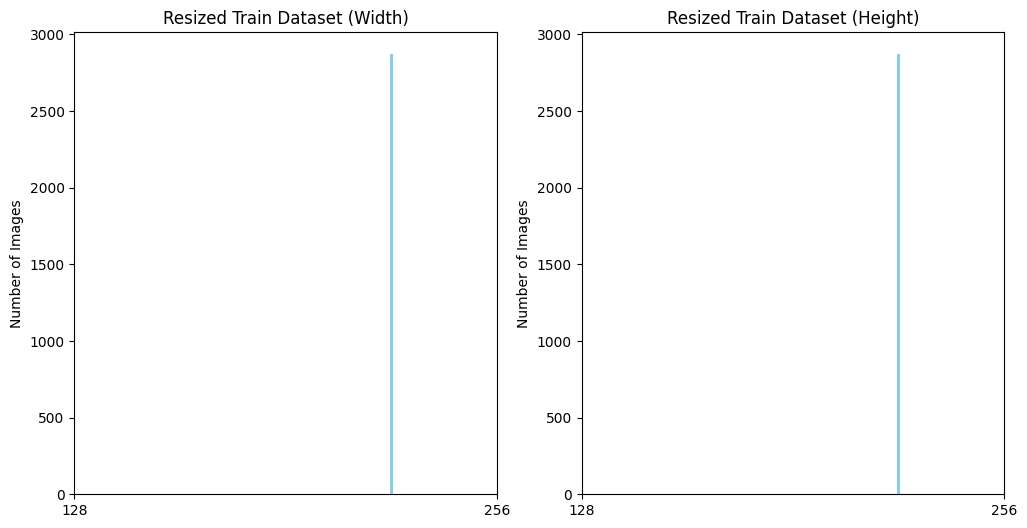

In [89]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

resized_train_dataset = BrainTumorDataset("Training", transform=transform)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_size_distribution(resized_train_dataset, "Resized Train Dataset", axes[0], dimension='width', bins=1)
plot_size_distribution(resized_train_dataset, "Resized Train Dataset", axes[1], dimension='height', bins=1)

In [90]:
def check_pixel_range(dataset):
    min_pixel_value = float('inf')
    max_pixel_value = float('-inf')

    for image, _ in dataset:
        image_min = image.min().item()
        image_max = image.max().item()

        min_pixel_value = min(min_pixel_value, image_min)
        max_pixel_value = max(max_pixel_value, image_max)
    
    print(f"Minimum Pixel Value: {min_pixel_value}")
    print(f"Maximum Pixel Value: {max_pixel_value}")

check_pixel_range(resized_train_dataset)

Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0


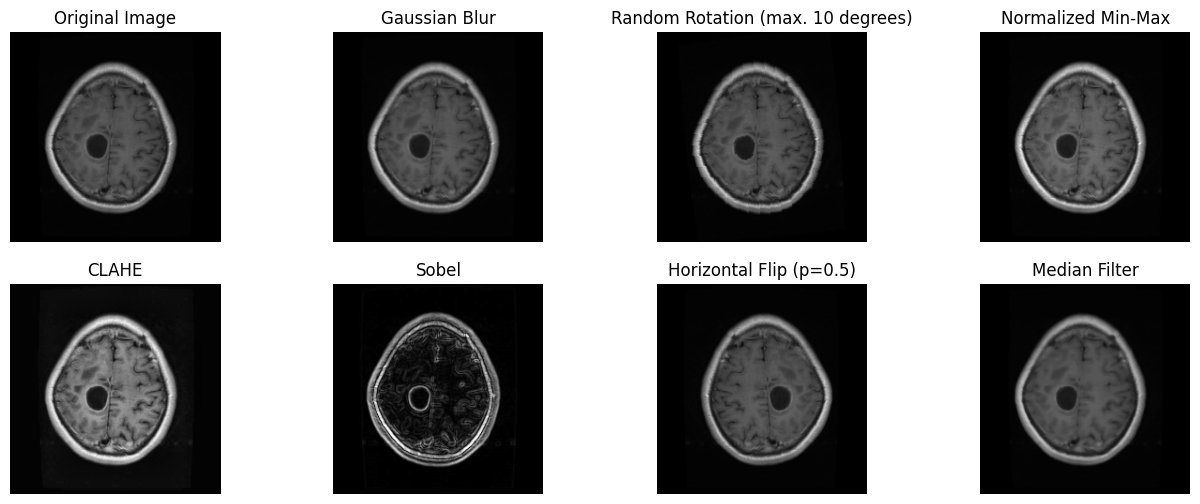

In [92]:
def plot_image(image, title, ax):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')


def normalize_min_max_tensor(image_tensor):
    image_tensor = image_tensor - image_tensor.min()
    image_tensor = image_tensor / image_tensor.max()
    return image_tensor


def apply_clahe_pil(pil_image):
    
    image_np = np.array(pil_image)
    
    
    if image_np.ndim == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image_np = clahe.apply(image_np)
    clahe_image_pil = Image.fromarray(clahe_image_np)
    
    if image_np.ndim == 2:
        clahe_image_pil = clahe_image_pil.convert('RGB')
    
    return clahe_image_pil


def apply_sobel_pil(pil_image):
    image_np = np.array(pil_image)
    
    if image_np.ndim == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(image_np, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image_np, cv2.CV_64F, 0, 1, ksize=3)
    
    sobel_x = cv2.convertScaleAbs(sobel_x)
    sobel_y = cv2.convertScaleAbs(sobel_y)
    
    sobel_image_np = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)
    sobel_image_pil = Image.fromarray(sobel_image_np)
    
    if image_np.ndim == 2:
        sobel_image_pil = sobel_image_pil.convert('RGB')
    
    return sobel_image_pil


fig, axes = plt.subplots(2, 4, figsize=(16, 6))

original_image = resized_train_dataset[432][0]
pil_image = transforms.ToPILImage()(original_image)

gaussian_blur_image = transforms.GaussianBlur(kernel_size=5)(pil_image)
rotated_pil_image = transforms.RandomRotation(10)(pil_image)
normalized_min_max_pil_image = transforms.ToPILImage()(normalize_min_max_tensor(original_image))
clahe_pil_image = apply_clahe_pil(pil_image)
sobel_pil_image = apply_sobel_pil(pil_image)
horizontal_flip_pil_image = transforms.RandomHorizontalFlip(p=0.5)(pil_image)
median_pil_image = pil_image.filter(ImageFilter.MedianFilter(3))

plot_image(pil_image, "Original Image", axes[0][0])
plot_image(gaussian_blur_image, "Gaussian Blur", axes[0][1])
plot_image(rotated_pil_image, "Random Rotation (max. 10 degrees)", axes[0][2])
plot_image(normalized_min_max_pil_image, "Normalized Min-Max", axes[0][3])
plot_image(clahe_pil_image, "CLAHE", axes[1][0])
plot_image(sobel_pil_image, "Sobel", axes[1][1])
plot_image(horizontal_flip_pil_image, "Horizontal Flip (p=0.5)", axes[1][2])
plot_image(median_pil_image, "Median Filter", axes[1][3])

### Task 7

In [78]:
model = models.resnet18()
# Modify the final layer
model.fc = nn.Linear(model.fc.in_features, len(LABELS))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [79]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.CenterCrop(224), 
    transforms.RandomRotation(degrees=10),
    #transforms.RandomApply([apply_clahe_pil], p=1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    #transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.5),
    #transforms.RandomApply([apply_sobel_pil], p=1),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.RandomApply([normalize_min_max_tensor], p=1),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = BrainTumorDataset(root_dir='./Training', transform=train_transform)
train_set, val_set = split_train_val(train_set, val_size=0.2)
test_set = BrainTumorDataset(root_dir='./Testing', transform=test_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [80]:
def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    # We set the model to be in training mode
    model.train()

    total_train_loss = 0.0
    correct = 0
    dataset_size = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    # We iterate through all batches - 1 step is 1 batch of batch_size images
    for step, (images, labels) in bar:
        # We take the images and their labels and push them on GPU
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        # Reset gradients
        optimizer.zero_grad()

        # Obtain predictions
        pred = model(images)

        # Compute loss for this batch
        loss = criterion(pred, labels)

        # Compute gradients for each weight (backpropagation)
        loss.backward()

        # Update weights based on gradients (gradient descent)
        optimizer.step()

        # We keep track of the average training loss
        total_train_loss += (loss.item() * batch_size)
        
        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels).sum().item()
        dataset_size += batch_size

        epoch_loss = np.round(total_train_loss / dataset_size, 2)
        accuracy = np.round(100 * correct / dataset_size, 2)
        
        bar.set_postfix(Epoch=epoch, Train_Acc=accuracy, Train_Loss=epoch_loss)

    return accuracy, epoch_loss


def valid_epoch(model, dataloader, device, criterion, epoch):
    # We set the model in evaluation mode
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    # We keep track of correct predictions
    correct = 0

    # This is only for showing the progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)

    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        # The raw output of the model is a score for each class
        # We keep the index of the class with the highest score as the prediction
        _, predicted = torch.max(pred, 1)

        # We see how many predictions match the ground truth labels
        correct += (predicted == labels).sum().item()

        # We compute evaluation metrics - loss and accurarcy
        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_val_loss / dataset_size, 2)

        accuracy = np.round(100 * correct / dataset_size, 2)

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    return accuracy, epoch_loss


def run_training(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Check if we are using GPU
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    # For keeping track of the best validation accuracy
    top_accuracy = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # We train the emodel for a number of epochs
    for epoch in range(num_epochs):

        train_accuracy, train_loss = train_epoch(model, train_loader, device, optimizer, criterion, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # For validation we do not keep track of gradients
        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, val_loader, device, criterion, epoch)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy} ---> {val_accuracy})")
                top_accuracy = val_accuracy
        print()

    return train_losses, val_losses, train_accuracies, val_accuracies



train_losses, val_losses, train_accuracies, val_accuracies = run_training(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)

[INFO] Using GPU: NVIDIA GeForce GTX 1080

100%|██████████| 18/18 [00:03<00:00,  4.62it/s, Epoch=0, Valid_Acc=47, Valid_Loss=1.83]  
Validation Accuracy Improved (0.0 ---> 47.04)

100%|██████████| 18/18 [00:03<00:00,  4.64it/s, Epoch=1, Valid_Acc=56.3, Valid_Loss=1.46]
Validation Accuracy Improved (47.04 ---> 56.27)

100%|██████████| 18/18 [00:03<00:00,  4.87it/s, Epoch=2, Valid_Acc=57.7, Valid_Loss=1.18]
Validation Accuracy Improved (56.27 ---> 57.67)

100%|██████████| 18/18 [00:03<00:00,  4.86it/s, Epoch=3, Valid_Acc=62.7, Valid_Loss=0.98]
Validation Accuracy Improved (57.67 ---> 62.72)

100%|██████████| 18/18 [00:03<00:00,  4.99it/s, Epoch=4, Valid_Acc=81.2, Valid_Loss=0.54]
Validation Accuracy Improved (62.72 ---> 81.18)

100%|██████████| 18/18 [00:03<00:00,  4.94it/s, Epoch=5, Valid_Acc=69, Valid_Loss=0.8]   

100%|██████████| 18/18 [00:04<00:00,  4.49it/s, Epoch=6, Valid_Acc=81.7, Valid_Loss=0.55]
Validation Accuracy Improved (81.18 ---> 81.71)

100%|██████████| 18/18 [00:04<00:0

                  precision    recall  f1-score   support

    glioma_tumor     0.7600    0.1900    0.3040       100
meningioma_tumor     0.6538    0.8870    0.7528       115
        no_tumor     0.5965    0.9714    0.7391       105
 pituitary_tumor     0.9524    0.5405    0.6897        74

        accuracy                         0.6675       394
       macro avg     0.7407    0.6472    0.6214       394
    weighted avg     0.7216    0.6675    0.6234       394



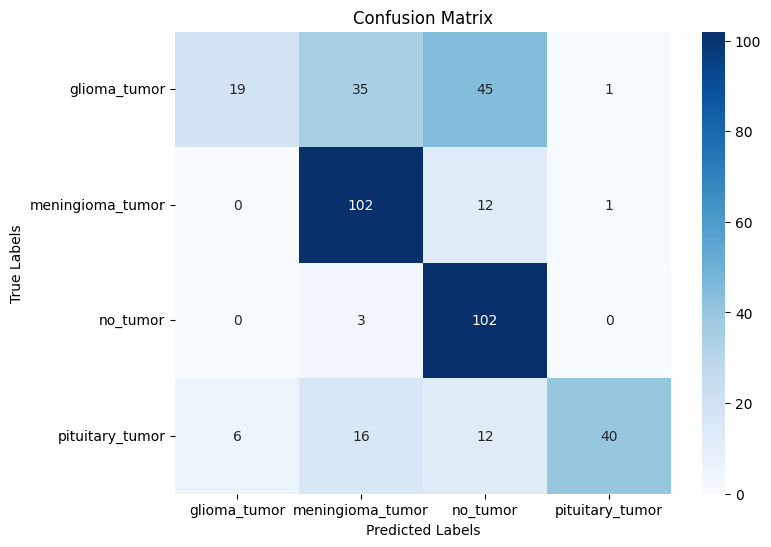

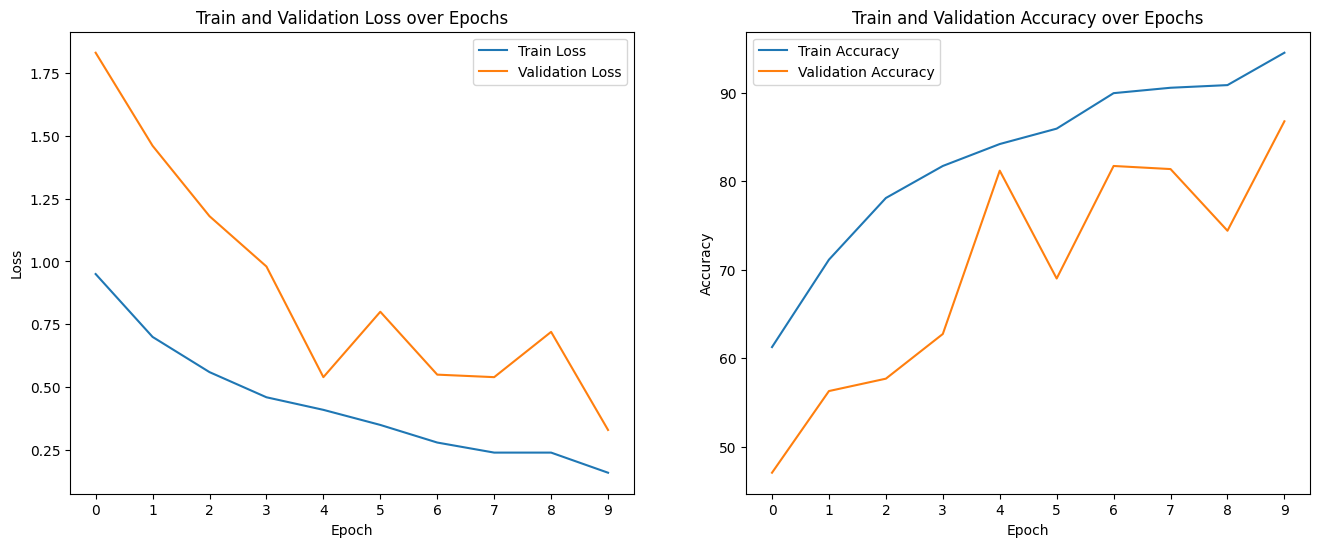

In [81]:
def evaluate_model():
    model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for test_data in test_loader:

            test_images, test_labels = (
                test_data[0].to(device),
                test_data[1].to(device),
            )

            pred = model(test_images).argmax(dim=1)

            for i in range(len(pred)):
                y_true.append(test_labels[i].item())
                y_pred.append(pred[i].item())

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=LABELS, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Train and Validation Loss and Accuracy
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    axes[0].plot(train_losses, label='Train Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Train and Validation Loss over Epochs')
    axes[0].set_xticks(range(0, NUM_EPOCHS))

    axes[1].plot(train_accuracies, label='Train Accuracy')
    axes[1].plot(val_accuracies, label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].set_title('Train and Validation Accuracy over Epochs')
    axes[1].set_xticks(range(0, NUM_EPOCHS))

evaluate_model()